# Image Captioning using Transformer

## 1.0 Model Output Analysis

### 1.1 Initialization 

Loading some library

In [1]:
from typing import List
from numpy.typing import NDArray

from pathlib import Path

import numpy as np
import pandas as pd

%matplotlib inline

from utils.exp_utils import plot_hist

Initialize some variables

In [2]:
project_data_dir = "/srv/data/guszarzmo/mlproject/data"
datasets_dir = "/srv/data/guszarzmo/mlproject/data/mscoco_h5"
result_dir = "/srv/data/guszarzmo/mlproject/data/test_out"
experiment_name = "0102.1513"

### 1.2 Loading Data

#### 1.2.1 Load test images `hdf5` file

In [3]:
import h5py

with h5py.File(str(Path(datasets_dir) / "test_images.hdf5")) as h5_file:
    images_nm, = h5_file.keys()
    images = np.array(h5_file[images_nm])

# make channel in the last dim, then (BGR -> RGB)
images: NDArray = np.einsum("bchw->bhwc", images)[..., ::-1]

print("min, max = ", images.min(), ",", images.max())
print("images array type: ", images.dtype)


min, max =  0 , 255
images array type:  uint8


#### 1.2.2 Load training data

I will examine the caption lengthes generated by the model and comparing it with the training data.

In [53]:
from utils.train_utils import load_json
from itertools import chain

train_lengthes = load_json(str(Path(datasets_dir) / "train_lengthes.json"))
# flat list of list
train_lengthes = np.array(list(chain.from_iterable(train_lengthes)), dtype=int)
print(train_lengthes[:10])

[11 12 14 12 31 13 13 10 13 12]


In [54]:
from statistics import mean

print("min captions len in train split:  ", min(train_lengthes))
print("max captions len in train split:  ", max(train_lengthes))
print("Mean captions len in train split: ", mean(train_lengthes))

min captions len in train split:   8
max captions len in train split:   52
Mean captions len in train split:  13


#### 1.2.3 Load results from `code/inference_test.py`

In [3]:
results_path = Path(result_dir) / experiment_name / "selected.pickle"
test_results_df: pd.DataFrame = pd.read_pickle(str(results_path))

In [4]:
display(test_results_df.head(3))

,hypos_text,refs_text,attns,bleu1,bleu2,bleu3,bleu4,gleu,meteor
0,"[A, couple, of, people, sitting, on, a, sidewa...","[[A, woman, shows, a, man, her, cellphone, whi...","[[[0.007849433459341526, 0.007953471504151821,...",0.666667,0.408248,0.287685,0.211053,0.142857,0.320513
1,"[A, pile, of, green, bananas, sitting, on, top...","[[The, bananas, were, picked, off, of, the, tr...","[[[0.00808838289231062, 0.0082778325304389, 0....",0.666667,0.348155,0.229711,0.161090,0.190476,0.364706
2,"[a, person, riding, a, motorcycle, on, a, race...","[[A, motorcycle, racer, leans, in, low, to, ma...","[[[0.007322345860302448, 0.00776868499815464, ...",0.716531,0.670254,0.612626,0.535732,0.285714,0.678419


### 1.3 Examining The Generated Captions Length

As we can see in the histogram [below](#len_hist), the distribution of the lengths in the training set is positively skewed. Thus, the model tends to generate shorter captions. As we can see in [this cell](#perc_of_max), the max text length generated by the model form 98.66% of the text lengths in the training set.

In [57]:
test_lengthes = test_results_df.agg({"hypos_text": lambda x: len(x)})
test_lengthes = test_lengthes.to_numpy().reshape(-1)

In [58]:
print("min captions len in test split:  ", min(test_lengthes))
print("max captions len in test split:  ", max(test_lengthes))
print("Mean captions len in test split: ", mean(test_lengthes))

min captions len in test split:   7
max captions len in test split:   21
Mean captions len in test split:  10


<a id="len_hist"></a>

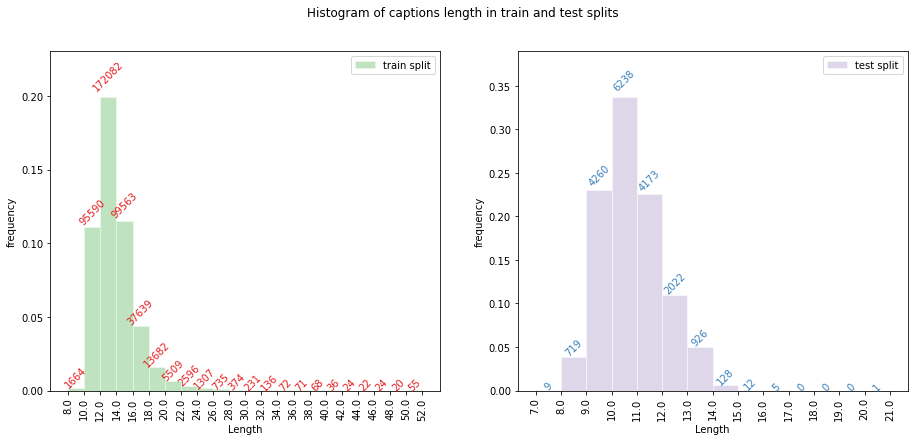

In [59]:
title = "Histogram of captions length in train and test splits "
label_x = "Length"
label_y = "frequency"
label_hist = ["train split", "test split"]
fig_data = {
    "label_h": label_hist,
    "xlabel": label_x,
    "ylabel": label_y,
    "title": title
}
figs, axes = plot_hist(data=[train_lengthes, test_lengthes],
                       fig_data=fig_data,
                       bins=[list(range(8, 53, 2)),
                             list(range(7, 22, 1))],
                       count=True)


<a id="perc_of_max"></a>

In [60]:
from scipy import stats

value = stats.percentileofscore(train_lengthes, max(test_lengthes), kind="weak")
print(f"{value:.2f}% of the training captions have length less than or equal to the maximum length generated by the model.")

98.66% of the training captions have length less than or equal to the maximum length generated by the model.


### 1.4 Examining the Performance Metrics

Metrics calculated during test are:
  1. Cumulative bleu scores: 1 to 4 n-grams [[1]](#refs)
  2. gleu score [[2]](#refs)
  3. meteor score [[3]](#refs)
  
Bleu4 is used to track the model performance during the training phase. According to its value, the learning rate is adjusted.

As we can see from [this cell below](#metrics_mdev), the bleu4 has the highest deviation (nearly equal to the mean value), suggesting that the performance varies across the dataset. Also, the distribution of the bleu4 scores over the test set shows that 83.3% of the scores are less than 0.5.

<a id="metrics_mdev"></a>

In [61]:
metrics_stats_df = test_results_df.loc[:, "bleu1":].agg(["mean", "std"])
metrics_stats_str_df = metrics_stats_df.agg(
    {
        "mean": lambda x: f"{x:.4f}",
        "std": lambda x: f"{x:.3f}"
    }, axis=1).apply(" \u00B1 ".join)
metrics_stats_str_df = pd.DataFrame(metrics_stats_str_df,
                                    columns=["mean \u00B1 std"]).T

display(metrics_stats_str_df)

,bleu1,bleu2,bleu3,bleu4,gleu,meteor
mean ± std,0.7180 ± 0.171,0.5116 ± 0.226,0.3791 ± 0.227,0.2918 ± 0.215,0.2814 ± 0.174,0.4975 ± 0.193


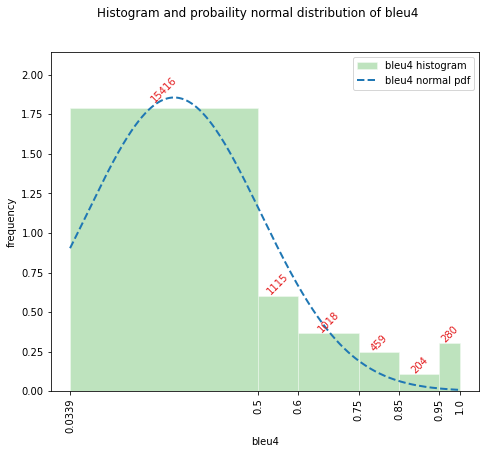

In [62]:
title = "Histogram and probaility normal distribution of bleu4"
label_x = "bleu4"
label_y = "frequency"
label_hist = "bleu4 histogram"
label_line = "bleu4 normal pdf"
fig_data = {
    "label_h": [label_hist],
    "label_l": [label_line],
    "xlabel": label_x,
    "ylabel": label_y,
    "title": title
}

bleu4 = test_results_df["bleu4"].to_numpy()
bins = [round(min(bleu4), 4), 0.5, 0.6, 0.75, 0.85, 0.95, round(max(bleu4), 4)]
fig, ax = plot_hist(data=[bleu4],
                    fig_data=fig_data,
                    bins=[bins],
                    norm_pdf=True,
                    count=True)


### 1.5 Attention Analysis

Here, I will examine the transformer encode/decoder attention. I took the last layer of the decoder"s attention and averaged the weights across the decoder heads. 

The [histogram](#metrics_hist) of the attention weights below suggests that there are outliers. I will consider weights that far from [99.95% percentile and higher](#metrics_outlier) as outliers. Outliers will be capped to the value of 99.95% percentile. As shown [below](#metrics_outlier), 0.050% have been changed. The new distribution after capping the outliers is shown [after](#metrics_hist_new).

In [63]:
# get min and max value of the attention

attns_list: List[List[List[float]]] = test_results_df["attns"].to_list()
attns: List[NDArray] = []
attns_flat: List[float] = []

for attn in attns_list:
    attns.append(np.array(attn))
    attns_flat.extend(attns[-1].reshape(-1))

minv = min(attns_flat)
maxv = max(attns_flat)
print("max value in attention: ", minv)
print("min value in attention: ", maxv)

max value in attention:  0.00018288660794496536
min value in attention:  0.18058833479881287


<a id="metrics_hist"></a>

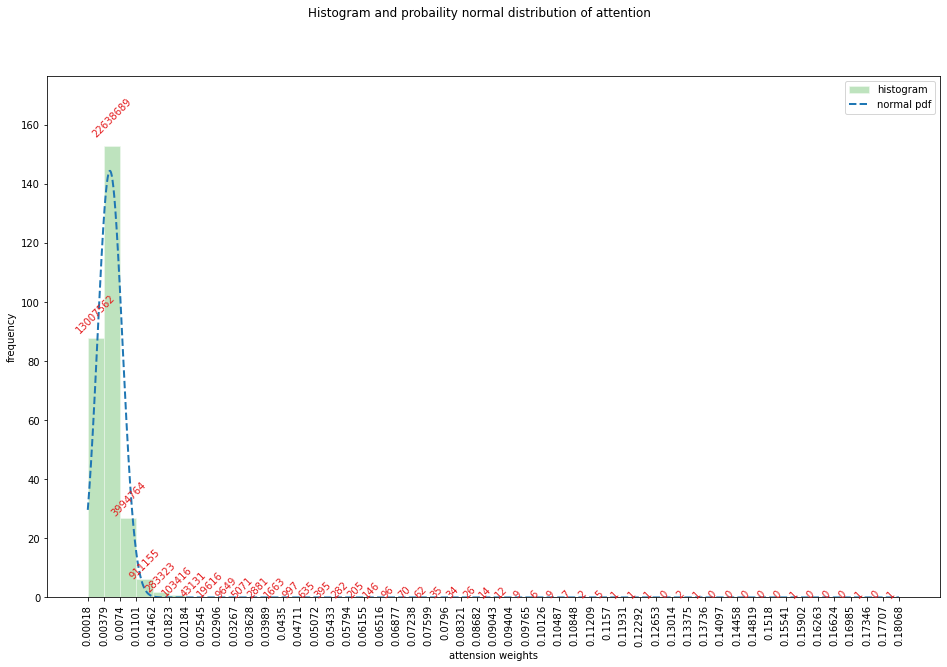

In [64]:
# visualize attention distribution
title = "Histogram and probaility normal distribution of attention"
label_x = "attension weights"
label_y = "frequency"
label_hist = "histogram"
label_line = "normal pdf"
fig_data = {
    "label_h": [label_hist],
    "label_l": [label_line],
    "xlabel": label_x,
    "ylabel": label_y,
    "title": title,
    "figsize_factor": (2.5, 2)
}
attns_flat = np.array(attns_flat)  # list->array
step = np.around((maxv - minv) / 50, 5)
bins = list(np.arange(minv, maxv + step, step))
fig, ax = plot_hist(data=[attns_flat],
                    fig_data=fig_data,
                    bins=[bins],
                    norm_pdf=True,
                    count=True)

<a id="metrics_outlier"></a>

In [65]:
# defining the outliers
q99 = np.quantile(a=attns_flat, q=0.9995)

# number of point will be capped
counts, _ = np.histogram(attns_flat, [attns_flat.min(), q99, attns_flat.max()])
print(f"percentage of data will be capped: {(counts[-1] / sum(counts)):.3%}")

percentage of data will be capped: 0.050%


In [66]:
# cap points >= quantile-0.9995
attns_capped: List[NDArray] = []
attns_capped_flat: List[float] = []
for attn in attns:
    ul = np.full_like(attn, fill_value=q99)  # upper limit array
    arr_capped = np.where(attn >= ul, ul, attn)
    attns_capped.append(arr_capped)
    attns_capped_flat.extend(arr_capped.reshape(-1))

attns_capped_flat = np.array(attns_capped_flat)
minv = attns_capped_flat.min()
maxv = attns_capped_flat.max()
print("max capped value:", maxv)
print("min value:", minv)

max capped value: 0.02958212001249272
min value: 0.00018288660794496536


<a id="metrics_hist_new"></a>

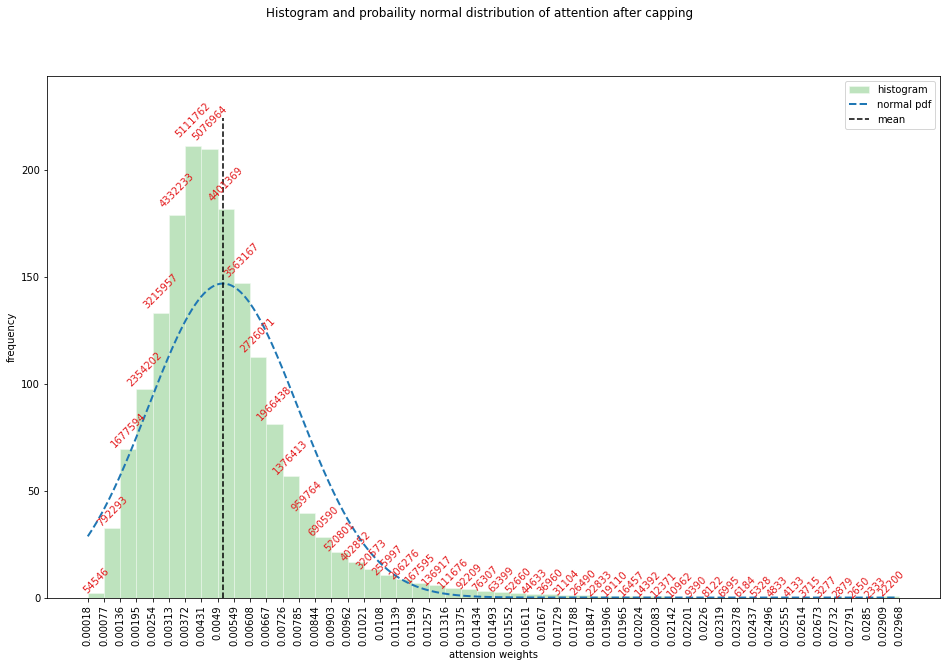

In [67]:
title = "Histogram and probaility normal distribution of attention after capping"
fig_data["title"] = title
# visualize attention distribution after capping data
step = np.around((maxv - minv) / 50, 5)
bins = list(np.arange(minv, maxv + step, step))
fig, ax = plot_hist(data=[attns_capped_flat],
                    fig_data=fig_data,
                    bins=[bins],
                    norm_pdf=True,
                    count=True)

mean_x = np.array([attns_capped_flat.mean()] * 2)
mean_y = np.array([0., ax[0][0].get_ylim()[1] * 0.919])
_ = ax[0][0].plot(mean_x, mean_y, color="k", linestyle="--", label="mean")
_ = ax[0][0].legend()

### 1.6 Captions Generation Analysis

#### 1.6.1 Process attention weights, images and texts

Here the attention for each generated word is superimposed on the images. The following images will be examined as follows:

  - Category 1: Random selected two samples that have the highes bleu4= 1.0
  - Category 2: Four samples that have the lowest bleu4 scores
  - Category 3: Random selected two samples that have the low value of bleu4 [up to to 0.5]
  - Category 4: Random selected two samples that have bleu4 score= (0.5 - 0.7]
  - Category 5: Random selected two samples that have bleu4 score=(0.7 - 0.8]
  - Category 6: Random selected two samples that have bleu4 score= (0.8 - 1.0)

In [68]:
import PIL
from PIL import Image
from tqdm.notebook import tqdm

# resize attentions to be superimposed on image
# from 14x14 to 300 x 300

attns_resize = []
for attn_seq in tqdm(attns_capped):
    for attn_word in attn_seq:
        attn = Image.fromarray(attn_word)
        attn = np.array(attn.resize((300, 300), PIL.Image.LANCZOS))
        attns_resize.append(attn)

attns_resize = np.stack(attns_resize)  # list(arr) -> ndarr
# min and max to be used to normalize the range [0-1]
minv = attns_resize.min()  
maxv = attns_resize.max()

# get it back to list of NDArrs. len of the list = number of test sample =
# number of raw in test results dataframe
attns_resize = np.split(attns_resize,
                        indices_or_sections=np.cumsum(test_lengthes + 1)[:-1])
assert len(attns_resize) == test_lengthes.shape[0]

print(
    f"number of test samples: {len(attns_resize)}\nattension size after resize: {attns_resize[0].shape}"
)
print(
    f"min value in attention is {minv:.5f}\nmax value in attention is {maxv:.5f}"
)


  0%|          | 0/18493 [00:00<?, ?it/s]

number of test samples: 18493
attension size after resize: (10, 300, 300)
min value in attention is -0.01039
max value in attention is 0.04344


In [69]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
from utils.exp_utils import visualize_attention
from matplotlib.colors import Normalize


# resize images
def image_resize(image):
    image_r = Image.fromarray(image).resize((300, 300), PIL.Image.LANCZOS)
    image_r = np.array(image_r)
    return image_r


# normalize ranges to be from 0-1
def normalize(attn, minv=minv, maxv=maxv):
    return Normalize(vmin=minv, vmax=maxv)(attn)


# convert series of images to a gif
def save_gif(save_dir: Path, idx: int, score: float):
    score = f"{int(score * 100000):05d}"
    fp = str(save_dir / f"vis_i{idx:05d}-s{score}.gif")
    img, *imgs = [
        Image.open(f).convert("P", palette=Image.ADAPTIVE)
        for f in sorted(save_dir.glob(f"*{idx}*.png"))
    ]
    img.save(fp=fp,
             format="GIF",
             append_images=imgs,
             save_all=True,
             dpi=(600, 600),
             duration=1800)
    return fp


# Superimpose attention on image for each word in the generated caption, then generate gif
def run_visualize_attention(image_ndarr, attn_list, refs_list, hypos_list,
                            bleu4_scores, save_dir, idx):
    
    # idx: define test sample ids that will be examine
    
    detokenize = TreebankWordDetokenizer().detokenize

    image_list = [image_resize(image_ndarr[i]) for i in idx]
    attn_norm_list = [normalize(attn_list[i]) for i in idx]
    txt_gen_list = [hypos_list[i][:-1] for i in idx]  # remove fullstop
    
    # Join ground truth captions: for each test sample, join the most inner list of str
    # to generate a sentence string. Each sample has a 5 sentences.
    text_gt_list = [
        "\n".join([
            f"{j+1}. {detokenize(rl for rl in ref)}"
            for j, ref in enumerate(refs_list[i])
        ]) for i in idx
    ]
    
    bleu4_list = [bleu4_scores[i] for i in idx]  # get bleu4 score
    
    # directory to save images for each word and the combined gif.
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # superimpose attention for each word then generate gifs
    gif_paths = []
    for data in zip(image_list, attn_norm_list, text_gt_list, txt_gen_list,
                    bleu4_list, idx):

        visualize_attention(*data, save_dir)
        gif_paths.append(save_gif(save_dir, data[-1], data[-2]))

    return gif_paths

In [5]:
save_dir = "../images/tests"
hypos: List[List[str]] = test_results_df["hypos_text"].to_list()
refs: List[List[List[str]]] = test_results_df["refs_text"].to_list()
bleu4s: pd.Series = test_results_df["bleu4"]

In [22]:
from utils.train_utils import seed_everything

seed_everything(9001)

idx_h = np.random.choice(bleu4s[bleu4s == 1.].index.to_numpy(),
                         2,
                         replace=False)
idx_l = bleu4s.nsmallest(n=4, keep="all").index.to_numpy()

# remove the selected lowest value and value == 1.
idx_one = bleu4s[bleu4s == 1.].index.to_numpy()
bleu4s_new: pd.Series = bleu4s[~(bleu4s.index.isin(idx_l)
                                 | bleu4s.index.isin(idx_one))]

idx_l1 = np.random.choice(bleu4s_new[bleu4s_new <= 0.5].index.to_numpy(),
                          2,
                          replace=False)
idx_l2 = np.random.choice(bleu4s_new[(bleu4s_new > 0.5) *
                                     (bleu4s_new <= 0.7)].index.to_numpy(),
                          2,
                          replace=False)
idx_h1 = np.random.choice(bleu4s_new[(bleu4s_new > 0.7) *
                                     (bleu4s_new <= 0.8)].index.to_numpy(),
                          2,
                          replace=False)
idx_h2 = np.random.choice(
    bleu4s_new[(bleu4s_new > 0.8) *
               (bleu4s_new <= bleu4s_new.max())].index.to_numpy(),
    2,
    replace=False)

print(f"indices of category 1: {idx_h}")
print(f"indices of category 2: {idx_l}")
print(f"indices of category 3: {idx_l1}")
print(f"indices of category 4: {idx_l2}")
print(f"indices of category 5: {idx_h1}")
print(f"indices of category 6: {idx_h2}")

indices of category 1: [ 5335 16214]
indices of category 2: [13078  2006 11178  5080]
indices of category 3: [1762 7909]
indices of category 4: [10020  6621]
indices of category 5: [ 3605 17305]
indices of category 6: [17308  9776]


In [23]:
from functools import partial

vis_fn = partial(run_visualize_attention, images, attns_resize, refs, hypos,
                 bleu4s)
idxs = [idx_h, idx_l, idx_l1, idx_l2, idx_h1, idx_h2]
gif_paths = []
for i, idx in enumerate(tqdm(idxs)):
    gif_paths.append(vis_fn(f"{save_dir}/cat-{str(i + 1)}", idx))

  0%|          | 0/6 [00:00<?, ?it/s]

#### 1.6.2 Examine Some Linguistcs Features

By scanning captions generated by the mode, I notice that the linguistic capability of the model is limited. Most of the captions are noun phrases (75.84%) that consist of:
  1. two noun phrases bound with a gerund verb $NP \rightarrow NP + VP$ , and
     $VP \rightarrow VBG + NP $; account for 56.05% of test split size. Note there is only one VGB
     in the caption,
  2. two noun phrases bound with an adposition $NP \rightarrow NP + ADP + NP$; account for 19.79% of test split size.

In [114]:
def get_tags(sent):
    pos = [word.upos for word in sent.words]
    if pos[-1] == "PUNCT":
        pos = pos[:-1]

    vids = [i for i, word in enumerate(sent.words) if word.upos == "VERB"]
    if len(vids) == 1:
        vid = vids[0]
        v_type = sent.words[vid].xpos
        np_ = pos[:vid]
        v_np = pos[vid + 1:]
        verb = sent.words[vid].text

    elif len(vids) == 0:
        v_type, v_np, verb = None, None, None
        np_ = pos

    else:
        v_type, v_np, np_, verb = None, None, None, None

    return pos, v_type, v_np, np_, verb


In [7]:
import stanza

nlp = stanza.Pipeline(lang="en",
                      processors="tokenize,pos",
                      tokenize_pretokenized=True,
                      use_gpu=False)

2022-03-20 12:13:33 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |

2022-03-20 12:13:34 INFO: Use device: cpu
2022-03-20 12:13:34 INFO: Loading: tokenize
2022-03-20 12:13:34 INFO: Loading: pos
2022-03-20 12:13:34 INFO: Done loading processors!


In [115]:
doc_hypo = nlp(hypos)

hypo_pos, hypo_vtype, vs_np, nps_, vs = [], [], [], [], []
nps_only = []
for sent in doc_hypo.sentences:
    pos, v_type, v_np, np_, verb = get_tags(sent)
    hypo_pos.append(pos)
    if v_type:
        hypo_vtype.append(v_type)
        vs_np.append(v_np)
        nps_.append(np_)
        vs.append(verb)
    elif np_ and v_type is None:
        nps_only.append(pos)


In [116]:
from collections import Counter
import pandas as pd
from IPython.display import display

hypo_vtype_counter = Counter(hypo_vtype).most_common()
hypo_vtype_counter_dict = {i: count for i, count in hypo_vtype_counter}

hypo_vtype_df = pd.DataFrame(hypo_vtype_counter_dict, index=["count"])
hypo_vtype_df = hypo_vtype_df.append(hypo_vtype_df / len(hypos),
                                     ignore_index=True).rename(index={
                                         0: "count",
                                         1: "%"
                                     })

display(hypo_vtype_df.T.style.format({"count": "{:.0f}", "%": "{:.2%}"}))
print("Percentage shown above is w.r.t the test split size")

,count,%
VBG,11257,60.87%
VBN,1163,6.29%
VBD,433,2.34%
VBZ,61,0.33%
VB,7,0.04%
VBP,6,0.03%


Percentage shown above is w.r.t the test split size


In [117]:
vbgp = [(" ".join(n1), " ".join(n2))
        for n1, v, n2 in zip(nps_, hypo_vtype, vs_np)
        if v == "VBG" and n1[-1] != "AUX"]

aux_vbgp = [(" ".join(n1), " ".join(n2))
            for n1, v, n2 in zip(nps_, hypo_vtype, vs_np)
            if v == "VBG" and n1[-1] == "AUX"]

nps_adp = [" ".join(x) for x in nps_only if "ADP" in x]

print(
    f'\n{len(vbgp)/len(hypos):.2%} is the perecetage of the generated samples that follows the [NP -> NP VP and VP -> VBG NP] from the test split size'
)

print(
    f'\n{len(nps_adp)/len(hypos):.2%} is the perecetage of the generated samples that follows the [NP -> NP ADP NP] from the test split size'
)


56.05% is the perecetage of the generated samples that follows the [NP -> NP VP and VP -> VBG NP] from the test split size

19.79% is the perecetage of the generated samples that follows the [NP -> NP ADP NP] from the test split size


In [125]:
verbs_per = {i: count/len(vs) * 100 for i, count in Counter(vs).most_common()}
small_per = {v for i, v in verbs_per.items() if v < 1.}
verbs_per_ = {i: count for i, count in verbs_per.items() if count >= 1.}
pd.DataFrame(verbs_per_, index=["percent"])

,sitting,standing,riding,filled,holding,parked,playing,flying,walking,laying,driving,topped,taking,traveling,wearing
percent,24.545525,19.130502,8.014234,4.687863,4.595034,4.239189,3.891081,3.05562,3.05562,2.939584,2.243367,1.941672,1.833372,1.40017,1.021119


In [71]:
from collections import defaultdict
from functools import partial

spatial_strs = ["under", "above", "next", "side"]

matches = defaultdict(list, {k: [] for k in spatial_strs})
for i, hypo in enumerate(hypos):
    for ss in spatial_strs:
        if ss in hypo:
            matches[ss].append(i)

idxs = defaultdict(list, {k[0]: [] for k in spatial_strs})
for ss in spatial_strs:
    bleu4s_ss = bleu4s.to_numpy()[matches[ss]]
    ids = np.argsort(bleu4s_ss)
    ids = np.array(matches[ss])[ids]
    idxs[ss[0]].extend([ids[0], ids[1], np.random.choice(ids[1:-1], 1)[0]])


vis_fn = partial(run_visualize_attention, images, attns_resize, refs, hypos,
                 bleu4s)
for cat, idx in idxs.items():
    vis_fn(f"{save_dir}/cat-{cat}", idx)


## 2.0 Model Output Visualizing

In [1]:
from pathlib import Path
import json

from IPython.display import HTML, display
from ipywidgets import Dropdown, Output, VBox, HBox, Layout, Button, Image

%matplotlib inline

In [2]:
results_path = "../logs/generated_captions.json"

with open(results_path, "r") as f:
    captions_gen = json.load(f)

In [4]:
style = {"description_width": "109px"}
item_layout = {"width": "300px"}
show_vis_layout = Layout(display="flex",
                         flex_flow="column",
                         align_items="flex-end",
                         width="300px")

box_layout = Layout(width="305px")
out_layout = Layout(width="auto",
                    flex_flow="row",
                    justify_content="flex-start")

vis_type = Dropdown(options=["Select", "Show Caption GIF", "Show by Word id"],
                    value="Select",
                    description="Visualization Type:",
                    disabled=False,
                    style=style,
                    layout=item_layout)

cat_type = Dropdown(
    options=[
        "1: bleu4=1.0", "2: lowest bleu4", "3: bleu4 <= 0.5 & not in 2",
        "4: 0.5 < bleu4 <= 0.7", "5: 0.7 < bleu4 <= 0.8",
        "6: 0.8 < bleu4 <= max & max != 1."
    ],
    description="Select Category:",
    disabled=True,
    style=style,
    layout=item_layout,
)

sample_idx = Dropdown(
    options=[],
    description="Select Sample id:",
    disabled=True,
    style=style,
    layout=item_layout,
)

word_ids = Dropdown(
    options=[],
    description="Select word id:",
    disabled=True,
    style=style,
    layout=item_layout,
)

show_vis = Button(
    description="Visualize Attention",
    disabled=True,
)

out = Output()


def reset_out():
    out.clear_output()
    with out:
        display(HTML("<p>Please select a visualization type.</p>"))


def image_html_formatter(image_path):
    import random
    __counter__ = random.randint(0, 2e9)
    html = f'<img src="{image_path}" ' + 'width="750">'
    return HTML(html)


def show_image(b):
    vis = vis_type.value
    out.clear_output()
    with out:
        if vis != "Select":
            idx = sample_idx.value
            cat = cat_type.value[0]
            wid = word_ids.value
            f_dir = Path(f"../images/tests/cat-{cat}")

            if wid is None:
                filepath = f_dir.glob(f"*{idx}*.gif")
            else:
                wid = int(wid.split(":")[0].strip())
                filepath = f_dir.glob(f"*{idx}*{wid:03d}.png")

            display(image_html_formatter(str(list(filepath)[0])))

        else:
            reset_out()


def get_words(idx):
    global captions_gen
    if idx is not None:
        return [
            f"{i+1:>2d}: {c}"
            for i, c in enumerate(captions_gen[int(idx)][:-1])
        ]


def get_sample_id(category):
    vis_dir = Path(f"../images/tests/cat-{category}")
    filelist = vis_dir.glob("*.gif")
    idx_list = [p.name[5:10] for p in filelist]
    return idx_list


def words_select(change):
    if change.old is not None and vis_type.value == "Show by Word id":
        word_ids.disabled = False
        word_ids.options = get_words(sample_idx.value)


def idx_select(change):
    if change:
        sample_idx.disabled = False
        sample_idx.options = get_sample_id(cat_type.value[0])


def type_select(change):
    if change.new != "Select":
        cat_type.disabled = False
        if not sample_idx.disabled:
            if vis_type.value == "Show by Word id":
                word_ids.options = get_words(sample_idx.value)
                if word_ids.disabled:
                    word_ids.disabled = False
            else:
                word_ids.disabled = True
                word_ids.options = []

        show_vis.disabled = False
    else:
        cat_type.disabled = True
        sample_idx.disabled = True
        word_ids.disabled = True
        show_vis.disabled = True
        cat_type.value = cat_type.options[0]
        sample_idx.options = []
        word_ids.options = []
        reset_out()


vis_type.observe(type_select, "value")
cat_type.observe(idx_select, ["value", "disabled"])
sample_idx.observe(words_select, "value")
show_vis.on_click(show_image)

# image_display = interactive(show_image, {"v": vis_type, "c": cat_type, "idx": sample_idx, "word": word_ids})
# image_box = HBox([image_display], layout=image_layout)

show_vis_box = HBox(children=[show_vis], layout=show_vis_layout)
out_box = HBox([out], layout=out_layout)

form = VBox([vis_type, cat_type, sample_idx, word_ids, show_vis_box],
            layout=box_layout)
form = HBox([form, out_box], layout={"width": "1110px", "height": "auto"})

display(form)
reset_out()

<a id="refs"></a>

## 3.0 References:

[1] Papineni, K., Roukos, S., Ward, T., & Zhu, W. J. (2002, July). Bleu: a method for automatic evaluation of machine translation. In Proceedings of the 40th annual meeting of the Association for Computational Linguistics (pp. 311-318).

[2] Wu, Y., Schuster, M., Chen, Z., Le, Q. V., Norouzi, M., Macherey, W., ... & Dean, J. (2016). Google's neural machine translation system: Bridging the gap between human and machine translation. arXiv preprint arXiv:1609.08144.

[3] Banerjee, S., & Lavie, A. (2005, June). METEOR: An automatic metric for MT evaluation with improved correlation with human judgments. In Proceedings of the acl workshop on intrinsic and extrinsic evaluation measures for machine translation and/or summarization (pp. 65-72).